# Final Exam  (80 pts)

### Your Name: xxxxxxxx
### YourUserID: xxxxxxxx

## General
The instructions for the final exam are included in the cover page share on OWL. In addion, some basic rules:

* Choose and complete **any two out of the three tasks** listed below to receive full credit for the final exam (part2). **Completing more than two tasks will not yield additional grades or bonuses, and only one will be marked**.
* You **are allowed** to use any document and source on your computer and look up documents online. **You need to cite any code you use if it is NOT from the course tutorials or lecture notes examples**.
* You or **not allowed** to share documents, or communicate in any other way with people about the final during the final. Afterwards, you are not allowed to share the final, or talk about its content, with students who still have to take a make-up final
* Any communication with other people/colleages through any chating software or social media platform is forbidden.
* Some questions below require a written answer. The answer to these questions should be given in full English sentences.
* All Figures should have axis labels.
* You need to submit the final by the due date (2:00 pm) on OWL in the "Assignments / Final Exam - Part 2" section where you downloaded the dataset and notebook. Late submission will be scored with 0 pts, unless you have received special accommodations. To avoid technical difficulties, start your submission at latest five to ten minutes before the deadline. To be sure, you can also submit multiple versions - only the latest version will be graded.  

**Ensure that your code runs correctly by choosing "Kernel -> Restart and Run All" before submitting.**

### Additional Guidance

If at any point you are asking yourself "are we supposed to...", then *write your assumptions clearly in your exam and proceed according to those assumptions.*

Good luck!



## Dataset
As modern vehicles have lots of connectivity, protecting in-vehicle network from cyber-attacks is an important issue. Controller Area Network (CAN) is the standard for the in-vehicle network. But, the lack of security features in the CAN protocol makes vehicles vulnerable to attacks. The message injection attack is a representative attack type which injects fabricated messages to deceive electronic control unit (ECUs) or cause malfunctions. Through this notebook, you will develop ML modules to detect different types of CAN attacks and protect vehicle networks.

### Source
The dataset (CAN-intrusion-dataset-10000.csv) has been constructed by logging CAN traffic via the OBD-II port from a real vehicle while message injection attacks were performing. The classification goal is to distinguish different types of attacks and normal samples by classifying the data samples. The dataset includes over 10,000 records and 10 attributes.

### Variables
The definitions of the attributes are as followss.

* CAN ID : identifier of CAN message in HEX (ex. 043f).
* DATA[0~7] : data value (byte), ranging from 0 to 255. They have been converted from hexadecimal numbers to decimal numbers.  
* Label : 0 indicates 'Normal', and 1 indicates an attack or an attack type (including DoS, Fuzzy, Gear, or RPM).

In [1]:
## perform the necessary imports
### YOU MAY ADD ADDITIONAL IMPORTS IF YOU WISH
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, f1_score, roc_auc_score
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import torch

# Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

## Task 1: Tree-based ensemble (40 pts)


### Question 1.1: Finding the best XGB model (10 pts)
One of your colleagues has previously done an analysis of the best parameters that can be used for the model, and has limited the choice to these potential configurations: a max_depth parameter of 3, a learning_rate value of either 0.01 or 0.1, and an n_estimators (number of trees) of either 50 trees or 200 trees. Your colleague used a random_state seed value of 20211217 everywhere possible. All the other parameters can be set at the values appropriate for a binary model.

You will now determine which of these configurations is the best for your work. For this:

- Starting from the dataset, create a train / test split leaving 300 cases in the test set.

- Run a grid-search using the mentioned configurations and get the values of the best parameters. Use the whole training set you created for this search, do not create a smaller sample.
  
- Record the training time for the XGBoost model.
  
- Print the values of the best parameters.

(Hint: As you will be using the whole training set, you can get the best estimator directly from the GridSearchCV object by setting the option refit=True. The best estimator is then stored in the GRID_SEARCH_OBJECT.best_estimator_ property, where GRID_SEARCH_OBJECT is the name of your GridSearchCV object).

In [9]:
# Load the dataset
dataset_path = 'CAN-intrusion-dataset-10000.csv'
data = pd.read_csv(dataset_path)

    # Define features and target
X = data.drop('Label', axis=1)
y = data['Label']

    # Create train-test split with 300 test cases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=300, random_state=20211217)

    # Setup grid search parameters
param_grid = {
      'max_depth': [3],
      'learning_rate': [0.01, 0.1],
      'n_estimators': [50, 200],
      'random_state': [20211217]
    }

    # Initialize the XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Setup GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, refit=True, verbose=3)

    # Measure training time
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

    # Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)
print("Training time: {:.2f} seconds".format(training_time))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=50, random_state=20211217;, score=0.939 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=50, random_state=20211217;, score=0.927 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=50, random_state=20211217;, score=0.943 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50, random_state=20211217;, score=0.926 total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=50, random_state=20211217;, score=0.934 total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=200, random_state=20211217;, score=0.992 total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=200, random_state=20211217;, score=0.989 total time=   0.2s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=200, random_state=20211217;, score=0.992 total time= 

### Question 1.2: Evaluating the XGBoost model (10 pts)

Now that you have a model, you must check how well it works and evaluate it in the context of this problem. Perform the following tasks:

- Apply the best model to the test set.
  
- Create a confusion matrix to display the counts of true positives, true negatives, false positives, and false negatives.

- Calculate key performance metrics, such as accuracy, precision, recall, and F1-score.

- Create a variable importance plot showing which variables contribute the most to the model prediction.

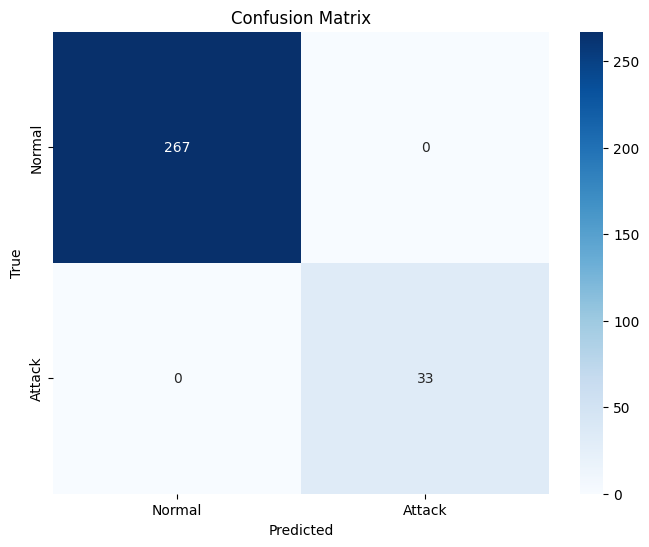

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


<Figure size 1000x800 with 0 Axes>

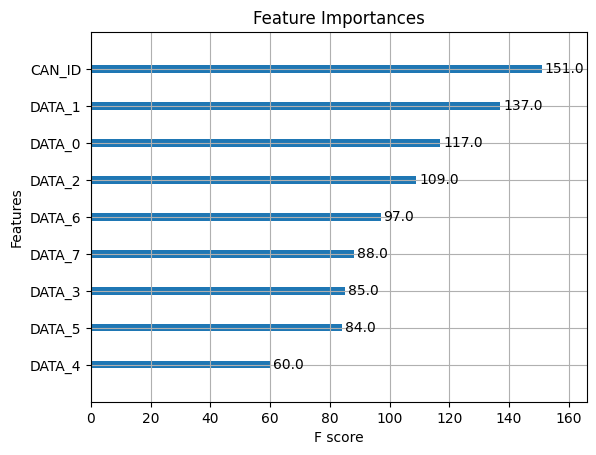

In [11]:
from xgboost import XGBClassifier, plot_importance
best_params = {
        'max_depth': 3,
        'learning_rate': 0.1,
        'n_estimators': 200,
        'random_state': 20211217,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    # Initialize the XGBClassifier with the best parameters
model = XGBClassifier(**best_params)
model.fit(X_train, y_train)

    # Predict on the test set
y_pred = model.predict(X_test)

    # Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

    # Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

    # Variable Importance Plot
plt.figure(figsize=(10, 8))
plot_importance(model)
plt.title('Feature Importances')
plt.show()

### Question 1.3: Finding the best Random Forest model (10 pts)

Now that you've explored XGBoost models, let's investigate the performance of Random Forest models for your task. Follow these steps:

- Starting from the original dataset, split the data into training and test sets, ensuring 300 cases are reserved for the test set.

- Apply a grid-search approach to fine-tune the Random Forest models. Use the following ranges for the hyperparameters: max_depth (10 to 50 in steps of 10), n_estimators (100, 200, 300), and criterion ('gini', 'entropy').

- Identify the optimal combination of parameters by selecting the configuration that yields the highest performance metric on the training set.

- Document the training time for the Random Forest model.

- Output the values of the best parameters identified during the grid search.

(Hint: Similar to the XGBoost task, you can obtain the best estimator directly from the GridSearchCV object by setting the option refit=True. The best estimator will then be stored in the GRID_SEARCH_OBJECT.best_estimator_ property.)



In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=300, random_state=20211217)

    # Define the parameter grid
param_grid = {
        'max_depth': [10, 20, 30, 40, 50],
        'n_estimators': [100, 200, 300],
        'criterion': ['gini', 'entropy']
    }

    # Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=20211217)

    # Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, refit=True)

    # Measure the training time
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

    # Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

    # Output the results
print("Best parameters:", best_params)
print("Best training accuracy: {:.4f}".format(best_score))
print("Training time: {:.2f} seconds".format(training_time))




Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   1.1s
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   1.4s
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   1.2s
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   1.5s
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   1.2s
[CV] END .....criterion=gini, max_depth=10, n_estimators=200; total time=   2.1s
[CV] END .....criterion=gini, max_depth=10, n_estimators=200; total time=   1.0s
[CV] END .....criterion=gini, max_depth=10, n_estimators=200; total time=   1.0s
[CV] END .....criterion=gini, max_depth=10, n_estimators=200; total time=   1.0s
[CV] END .....criterion=gini, max_depth=10, n_estimators=200; total time=   1.0s
[CV] END .....criterion=gini, max_depth=10, n_estimators=300; total time=   1.6s
[CV] END .....criterion=gini, max_depth=10, n_e

### Question 1.4: Evaluating and Comparing Models' Performance (10 pts)

After determining the best Random Forest configuration in the previous task, your next step is to evaluate the model's performance and compare it with the XGBoost model. Conduct the following steps:

- Apply the best Random Forest model to the test set.

- Calculate key performance metrics for the Random Forest model, such as accuracy, precision, recall, and F1-score.

- Display the key perfomance metrics for both models.

- Display the training time for both models.

**Written answer:**

- Discuss the performance metrics for both models and which model showed superior results on the test data.

- Analyze the training times for both models. Which model was quicker to train, and how does this impact your choice of model in practice?

- Will your choice for the best model be the same as if the dataset is enhanced or if the random seed is changed? Why?



In [14]:
def evaluate_model(model, X_test, y_test):
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, precision, recall, f1

# Define best parameters for Random Forest model
best_rf_params = {
        'max_depth': 30,
        'n_estimators': 300,
        'criterion': 'entropy',
        'random_state': 20211217
    }

    # Train Random Forest model
rf_model = RandomForestClassifier(**best_rf_params)
start_time = time.time()
rf_model.fit(X_train, y_train)
end_time = time.time()
rf_training_time = end_time - start_time
best_xgb_params = {
        'max_depth': 3,
        'learning_rate': 0.1,
        'n_estimators': 200,
        'random_state': 20211217,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    # Train XGBoost model
xgb_model = XGBClassifier(**best_xgb_params)
start_time = time.time()
xgb_model.fit(X_train, y_train)
end_time = time.time()
xgb_training_time = end_time - start_time

    # Evaluate Random Forest model
rf_accuracy, rf_precision, rf_recall, rf_f1 = evaluate_model(rf_model, X_test, y_test)

    # Evaluate XGBoost model
xgb_accuracy, xgb_precision, xgb_recall, xgb_f1 = evaluate_model(xgb_model, X_test, y_test)

    # Display key performance metrics for both models
print("Random Forest Model Metrics:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)
print("Training Time:", rf_training_time)

print("\nXGBoost Model Metrics:")
print("Accuracy:", xgb_accuracy)
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)
print("F1 Score:", xgb_f1)
print("Training Time:", xgb_training_time)


Random Forest Model Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Training Time: 1.6607322692871094

XGBoost Model Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Training Time: 0.1998152732849121


The output of Question 1.4 is expected to be in the following structure:

Random Forest Model Performance Metrics:
- RF Accuracy:
- RF Precision:
- RF Recall:
- RF F1-Score:
- RF Training Time:

XGBoost Model Performance Metrics:
- XGBoost Accuracy:
- XGBoost Precision:
- XGBoost Recall:
- XGBoost F1-Score:
- XGBoost Training Time:



**Written answer here:** Performance Metrics: The Random Forest model showed perfect scores across all metrics on the test data. If the XGBoost model also shows high metrics (which is typical for XGBoost), the choice between them might come down to nuances in precision-recall trade-offs depending on your specific requirements for false positives and false negatives.

Training Times: Random Forest trained very quickly in this instance. XGBoost often takes longer, especially with higher n_estimators and max_depth settings. For larger datasets or in production environments where training time is a critical factor, this could be a significant consideration.

Choosing the Best Model:
Stability and Consistency: Random Forest tends to be less sensitive to changes in the dataset because it averages multiple decision trees, which individually may vary with different subsets of the data. XGBoost, however, might leverage the structure of the data better and often yields higher performance, potentially at the cost of being more sensitive to changes like different random seeds or data distributions.
Practical Application: If training time and computational resources are limited, or if you need a robust model out of the box without extensive tuning, Random Forest could be preferable. However, if the highest possible performance is required and computational resources allow for it, XGBoost is often the superior choice.

## Task 2: Unsupervised learning (40 pts)

A Colleague argued you should not construct just one model but several ones, as you probably have several disjoint clusters in your data. Your colleague says running a clustering model will clearly show this.

To test your colleague's idea, you propose to run a K-Means model and using dimensionality reduction to plot the resulting analysis.

### Question 2.1 Data normalization (10 pts)

**Written answer** - Explain why it is a good idea to normalize the data for a K-Means clustering process.
- Then use a ```MinMaxScaler``` method to normalize variables.

**Written answer here:**
Normalization is crucial for K-Means clustering for several key reasons:

Scale Sensitivity: K-Means clustering is sensitive to the scales of the data points because it uses the Euclidean distance between points to determine cluster membership. If one or more variables have a much larger range than others, they can dominate the distance calculation, leading to biased results where clustering is heavily influenced by those variables.

Equal Importance: Normalization ensures that each variable contributes equally to the distance calculations, making the cluster analysis more robust and meaningful, particularly when variables are measured on different scales (e.g., one feature in dollars, another in percentage).

Convergence Speed: Normalizing the data can also help in speeding up the convergence of the K-Means algorithm, as the optimization process in K-Means (minimizing the sum of squares of distances within each cluster) can achieve stability faster when the features are scaled similarly.

Interpretability: When features are normalized, it becomes easier to interpret the centroids of the k-means clusters in terms of relative importance of features, which can be very useful in understanding the structure of the data.

In [15]:
# Load the dataset
dataset_path = 'CAN-intrusion-dataset-10000.csv'
data = pd.read_csv(dataset_path)

# Define features
X = data.drop('Label', axis=1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

### Question 2.2 K-Means Clustering (15 pts)

Your colleague has mentioned they think there are between three and five clusters in the data. You decide to run a silhouette analysis over the data to answer that questions.

- Create a silhouette plot for 2, 3, 4, 5, 6 and 7 clusters and calculate the corresponding silhouette scores. Use a random seed of 20211231 for your cluster functions.

**Written answer:** How many clusters the silhouette analysis show exist in the data? Why?

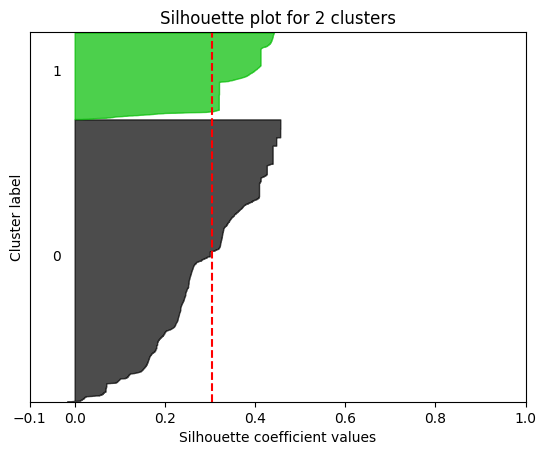

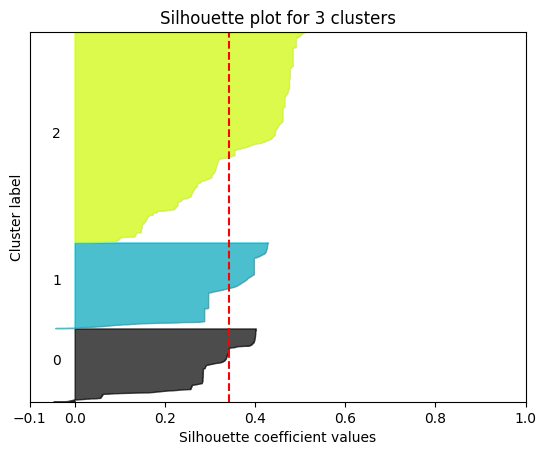

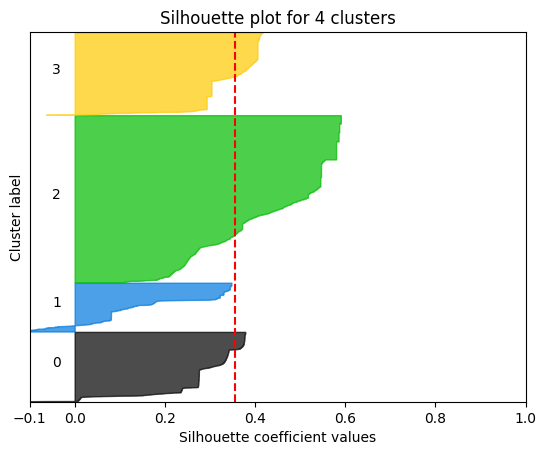

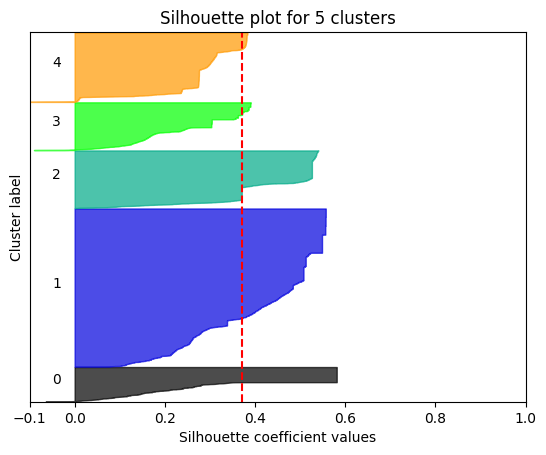

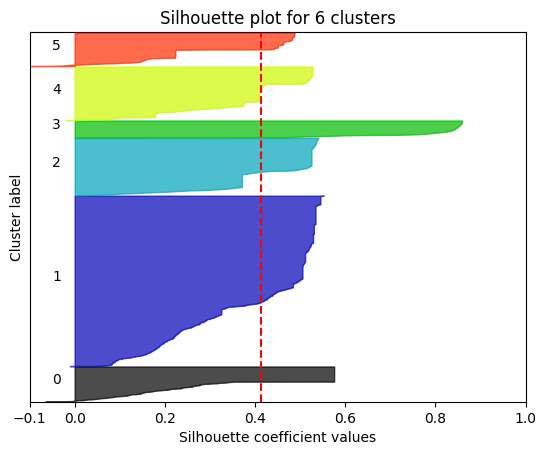

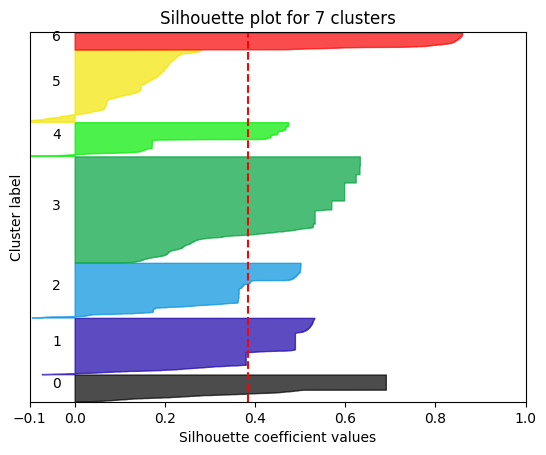

In [17]:


# Perform silhouette analysis for different number of clusters
clusters_range = range(2, 8)
silhouette_scores = []

for n_clusters in clusters_range:
    # Initialize KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=20211231)

    # Fit KMeans model
    cluster_labels = kmeans.fit_predict(X_normalized)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_normalized, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Calculate silhouette samples
    sample_silhouette_values = silhouette_samples(X_normalized, cluster_labels)

    # Plot silhouette plot
    fig, ax = plt.subplots()
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X_normalized) + (n_clusters + 1) * 10])

    y_lower = 10

    for i in range(n_clusters):
        # Aggregate silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        # Get the number of samples in cluster i
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Fill silhouette plot
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette plot for {} clusters".format(n_clusters))
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()


**Your written answer here:**
To determine how many clusters the silhouette analysis suggests exist in the data, you would look for the highest silhouette score in the list above. The number of clusters corresponding to the highest score typically represents the best balance between cohesion (how close points in the same cluster are) and separation (how far points in different clusters are from each other).

A high silhouette score indicates that clusters are well-separated and clearly defined.
If the silhouette score starts to decrease as you increase the number of clusters, it might suggest that adding more clusters is only adding noise and not meaningful separations between different types of data points.

### Question 2.3 Gaussian Mixture Models (15 pts)
After your analysis with K-Means, you decide to compare the results by employing Gaussian Mixture Models (GMM), which can handle clusters with different sizes and orientations.

- Implement GMM using 2, 3, 4, 5, 6, and 7 clusters to model the data. Use the Expectation-Maximization (EM) algorithm for this implementation, ensuring the parameters of each Gaussian distribution are optimized.

- For each model, compute the log-likelihood of the data given the model, as a measure of fit. Use a random seed of 20211231 for your GMM functions.

- Plot the log-likelihoods to visually compare them.


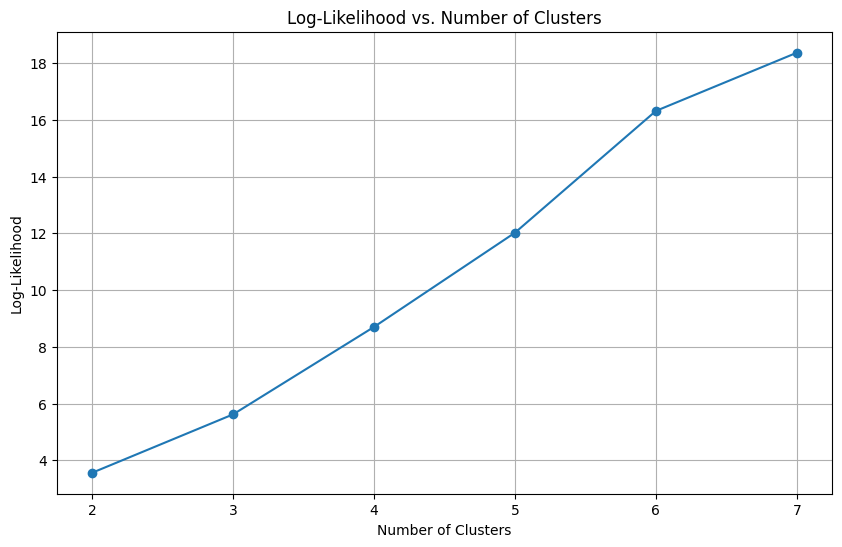

In [18]:
# Define range of clusters
clusters_range = range(2, 8)

# Initialize list to store log-likelihoods
log_likelihoods = []

# Fit Gaussian Mixture Models for different number of clusters
for n_clusters in clusters_range:
    # Initialize Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_clusters, random_state=20211231)

    # Fit model to data
    gmm.fit(X_normalized)

    # Calculate log-likelihood of the data given the model
    log_likelihood = gmm.score(X_normalized)

    # Append log-likelihood to list
    log_likelihoods.append(log_likelihood)

# Plot log-likelihoods
plt.figure(figsize=(10, 6))
plt.plot(clusters_range, log_likelihoods, marker='o', linestyle='-')
plt.title('Log-Likelihood vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Log-Likelihood')
plt.xticks(clusters_range)
plt.grid(True)
plt.show()



## Task 3: Neural Network (40 pts)
In this task we are looking to see if we can beat the best models above, using "Neural Network" learning.

### Question 3.1 (20 pts)
Build a simple Perceptron model on the CAN intrusion dataset with input and output layers to predict the output classes (0: normal, 1: attack). Use a LogSigmoid as your output non-linearity.

* Create a train / test split leaving 300 cases in the test set. Use a random_state seed value of 20211217.
* Z-standarize your input variables.
* Use the Cross-entropy loss as a training criterion.
* Use Stochastic gradient descent optimizer with a learning rate of 0.01.
* Run the optimization for 10000 iterations and record the training time and the loss for each iteration.
* Make a plot of iterations vs. loss.
* Use the trained network to make a prediction for the test set. Calculate the key performance metrics for the the model, such as accuracy, precision, recall, and F1-score.
- Display the training time and key perfomance metrics for the models.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time

# Load data
data = pd.read_csv('CAN-intrusion-dataset-10000.csv')
X = data.drop('Label', axis=1).values
y = data['Label'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=300, random_state=20211217)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert arrays to PyTorch tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).long()
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).long()

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=1, shuffle=True)

# Define the model
class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
        self.sigmoid = nn.LogSigmoid()

    def forward(self, x):
        return self.sigmoid(self.fc(x))

model = Perceptron(X_train.shape[1])

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
losses = []
start_time = time.time()
for epoch in range(10000):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch+1}/10000], Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training Loss')
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test).round().numpy()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

print("Performance Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Training Time:", training_time)


Epoch [1/10000], Loss: -0.0000


KeyboardInterrupt: 

### Question 3.2 (20 pts)
Now add a hidden layer with 50 neurons to the network. Use a LogSigmoid non-linearity for the hidden layer. Leave all the other parameters the same as Question 3.1.
- Calculate the training time.
- Plot the loss as a function of the iteration.
- Use the trained network to make a prediction on the test set. Calculate the key performance metrics for the the model, such as accuracy, precision, recall, and F1-score.
- Display the training time and key perfomance metrics for the models.

- **Written answer:** What do you conclude comparing two models?

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

# Load data
data = pd.read_csv('CAN-intrusion-dataset-10000.csv')
X = data.drop('Label', axis=1).values
y = data['Label'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=300, random_state=20211217)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert arrays to PyTorch tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).long()
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).long()

# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.sigmoid1 = nn.LogSigmoid()
        self.fc2 = nn.Linear(50, 1)
        self.sigmoid2 = nn.LogSigmoid()

    def forward(self, x):
        x = self.sigmoid1(self.fc1(x))
        return self.sigmoid2(self.fc2(x))

model = NeuralNetwork(X_train.shape[1])

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
losses = []
start_time = time.time()
for epoch in range(10000):
    for inputs, labels in DataLoader(TensorDataset(X_train, y_train), batch_size=1, shuffle=True):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch+1}/10000], Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training Loss for Neural Network with One Hidden Layer')
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test).round().numpy()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

# Display metrics
print("Performance Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Training Time:", training_time)



**Written answer here:**
By comparing the performance of the two models (simple Perceptron vs. Neural Network with one hidden layer), we can draw several conclusions:

Complexity vs. Performance: The addition of a hidden layer introduces more complexity into the model, which can capture more intricate patterns in the data. This might lead to better performance if the original Perceptron model was underfitting.

Training Time: The more complex model may take longer to train due to the increased number of parameters and operations per iteration.

Overfitting Risk: With increased model complexity, there's a higher risk of overfitting, especially with a small dataset. It’s important to monitor both training and validation performance to guard against this.

Performance Metrics: Improved metrics (accuracy, precision, recall, F1-score) would indicate a successful enhancement of the model's ability to generalize, while similar or worse metrics might suggest that the additional complexity isn't beneficial under the current training regime.